# SGNS 구현하기

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data
print('총 샘플 수 :',len(documents))

총 샘플 수 : 11314


In [ ]:
news_df = pd.DataFrame({'document':documents})
# 특수 문자 제거
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")
# 길이가 3이하인 단어는 제거 (길이가 짧은 단어 제거)
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
# 전체 단어에 대한 소문자 변환
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

In [ ]:
news_df.isnull().values.any()

False

In [ ]:
news_df.replace("", float("NaN"), inplace=True)
news_df.isnull().values.any()

True

In [ ]:
news_df.dropna(inplace=True)
print('총 샘플 수 :',len(news_df))

총 샘플 수 : 10995


In [ ]:
# 불용어를 제거
stop_words = stopwords.words('english')
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])
tokenized_doc = tokenized_doc.to_list()

In [ ]:
# 단어가 1개 이하인 경우 중심 단어, 주변 단어가 존재하지 않으므로 불가.
drop_train = [index for index, sentence in enumerate(tokenized_doc) if len(sentence) <= 1]

In [ ]:
print(drop_train)

[44, 260, 353, 1651, 1839, 2321, 2336, 2371, 2862, 2963, 3290, 3387, 3395, 3396, 3421, 3563, 3591, 3713, 3874, 3897, 4180, 4524, 4587, 4617, 4947, 4970, 5129, 5525, 6015, 6227, 6652, 6723, 6883, 7080, 7956, 8000, 8156, 8212, 8283, 8588, 8867, 8903, 9045, 9555, 9696, 10439, 10447, 10564, 10707, 10730, 10750, 10838, 10896, 10908, 10967]


In [ ]:
tokenized_doc = np.delete(tokenized_doc, drop_train, axis=0)

In [ ]:
print(len(tokenized_doc))

10940


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_doc)

word2idx = tokenizer.word_index
idx2word = {v:k for k, v in word2idx.items()}
encoded = tokenizer.texts_to_sequences(tokenized_doc)

In [ ]:
print(encoded[:2])

[[9, 59, 603, 207, 3278, 1495, 474, 702, 9470, 13686, 5533, 15227, 702, 442, 702, 70, 1148, 1095, 1036, 20294, 984, 705, 4294, 702, 217, 207, 1979, 15228, 13686, 4865, 4520, 87, 1530, 6, 52, 149, 581, 661, 4406, 4988, 4866, 1920, 755, 10668, 1102, 7837, 442, 957, 10669, 634, 51, 228, 2669, 4989, 178, 66, 222, 4521, 6066, 68, 4295], [1026, 532, 2, 60, 98, 582, 107, 800, 23, 79, 4522, 333, 7838, 864, 421, 3825, 458, 6488, 458, 2700, 4730, 333, 23, 9, 4731, 7262, 186, 310, 146, 170, 642, 1260, 107, 33568, 13, 985, 33569, 33570, 9471, 11491]]


In [ ]:
vocab_size = len(word2idx) + 1 
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 64277


토큰화, 정제, 정규화, 불용어 제거, 정수 인코딩까지 일반적인 전처리 과정을 거침. 네거티브 샘플링을 통한 데이터셋을 구성할 차례. 이를 위해서는 네거티브 샘플링을 위해서 케라스에서 제공하는 전처리 도구인 skipgrams를 사용. 어떤 전처리가 수행되는지 그 결과를 확인하기 위해서 (꽤 시간이 소요되는 작업이므로) 상위 10개의 뉴스그룹 샘플에 대해서만 수행.

In [ ]:
from tensorflow.keras.preprocessing.sequence import skipgrams
# 네거티브 샘플링
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded[:10]]

결과를 확인. 10개의 뉴스그룹 샘플에 대해서 모두 수행되었지만, 첫번째 뉴스그룹 샘플에 대해서만 확인.



In [ ]:
# 첫번째 샘플인 skip_grams[0] 내 skipgrams로 형성된 데이터셋 확인
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          idx2word[pairs[i][0]], pairs[i][0], 
          idx2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(europe (1095), industries (4874)) -> 0
(media (702), creators (28906)) -> 0
(degree (1530), backlighted (28592)) -> 0
(clearly (661), israeli (442)) -> 1
(austria (4866), dishonourable (54277)) -> 0
(think (6), reports (755)) -> 1
(ignore (1979), seem (207)) -> 1
(statement (474), world (70)) -> 1
(reports (755), daily (1920)) -> 1
(clearly (661), reason (149)) -> 1


윈도우 크기 내에서 중심 단어, 주변 단어의 관계를 가지는 경우에는 1의 레이블을 갖도록 하고, 그렇지 않은 경우는 0의 레이블을 가지도록 하여 데이터셋을 구성. 이 과정은 각각의 뉴스그룹 샘플에 대해서 동일한 프로세스로 수행.

In [ ]:
print('전체 샘플 수 :',len(skip_grams))

전체 샘플 수 : 10


In [ ]:
# 첫번째 뉴스그룹 샘플에 대해서 생긴 pairs와 labels의 개수
print(len(pairs))
print(len(labels))

2220
2220


이 작업을 모든 뉴스그룹 샘플에 대해서 수행.

In [ ]:
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded]

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input
from tensorflow.keras.layers import Dot
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

In [ ]:
embed_size = 100

In [ ]:
# 중심 단어를 위한 임베딩 테이블
w_inputs = Input(shape=(1, ), dtype='int32')
word_embedding = Embedding(vocab_size, embed_size)(w_inputs)

# 주변 단어를 위한 임베딩 테이블
c_inputs = Input(shape=(1, ), dtype='int32')
context_embedding  = Embedding(vocab_size, embed_size)(c_inputs)

In [ ]:
dot_product = Dot(axes=2)([word_embedding, context_embedding])
dot_product = Reshape((1,), input_shape=(1, 1))(dot_product)
output = Activation('sigmoid')(dot_product)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       6427700     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 100)       6427700     input_2[0][0]                    
_______________________________________________________________________________________

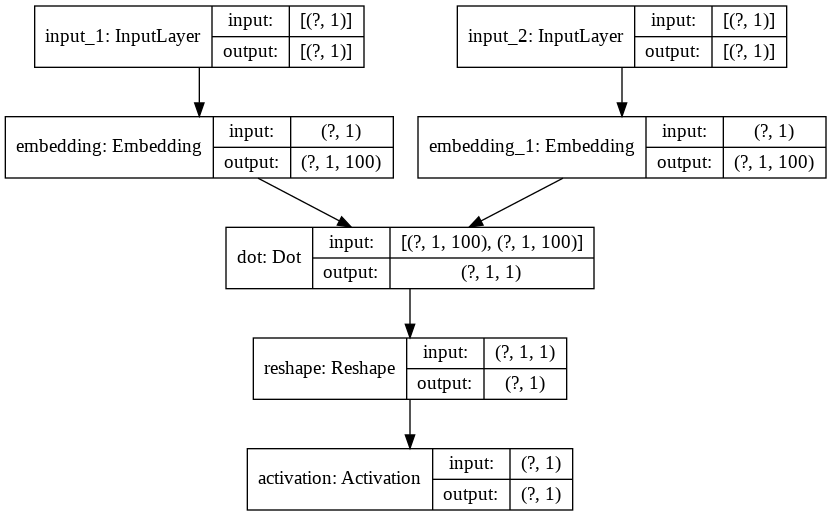

In [ ]:
model = Model(inputs=[w_inputs, c_inputs], outputs=output)
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam')
plot_model(model, to_file='model3.png', show_shapes=True, show_layer_names=True, rankdir='TB')

In [ ]:
for epoch in range(1, 6):
    loss = 0
    for _, elem in enumerate(skip_grams):
        first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [first_elem, second_elem]
        Y = labels
        loss += model.train_on_batch(X,Y)  
    print('Epoch :',epoch, 'Loss :',loss)

Epoch : 1 Loss : 4629.110517144203
Epoch : 2 Loss : 3670.3784894645214
Epoch : 3 Loss : 3510.197998929769
Epoch : 4 Loss : 3308.5524085350335
Epoch : 5 Loss : 3082.984006331302


In [ ]:
import gensim

In [ ]:
f = open('vectors.txt' ,'w')
f.write('{} {}\n'.format(vocab_size-1, embed_size))
vectors = model.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [ ]:
w2v = gensim.models.KeyedVectors.load_word2vec_format('./vectors.txt', binary=False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
w2v.most_similar(positive=['soldiers'])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('wounded', 0.8630685806274414),
 ('massacred', 0.8264391422271729),
 ('massacre', 0.822135329246521),
 ('shelling', 0.8160871267318726),
 ('slaughtered', 0.813990592956543),
 ('gazans', 0.8133612871170044),
 ('occupied', 0.8131306171417236),
 ('massacres', 0.8092026710510254),
 ('elderly', 0.8050550222396851),
 ('moslem', 0.8037423491477966)]

In [ ]:
w2v.most_similar(positive=['doctor'])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('clinic', 0.582487940788269),
 ('infection', 0.5769582390785217),
 ('pain', 0.5762976408004761),
 ('treatment', 0.563055694103241),
 ('chronic', 0.5581271648406982),
 ('treated', 0.5178740620613098),
 ('quack', 0.5115471482276917),
 ('stopping', 0.5095911026000977),
 ('swiss', 0.5059969425201416),
 ('diagnosis', 0.49491220712661743)]

In [ ]:
w2v.most_similar(positive=['police'])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('raids', 0.5848600268363953),
 ('violent', 0.566329836845398),
 ('officials', 0.5605665445327759),
 ('declined', 0.556200385093689),
 ('robbery', 0.5526008009910583),
 ('pretext', 0.5522351264953613),
 ('ghetto', 0.5508134365081787),
 ('voted', 0.5499347448348999),
 ('archery', 0.5481936931610107),
 ('bound', 0.5419867038726807)]

In [ ]:
w2v.most_similar(positive=['knife'])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('handgun', 0.7971947193145752),
 ('azerbaijani', 0.7935985326766968),
 ('gazans', 0.7899342775344849),
 ('elderly', 0.7781503200531006),
 ('murders', 0.76943439245224),
 ('struggling', 0.7655448913574219),
 ('kurd', 0.759674072265625),
 ('azerbaijanis', 0.7571895122528076),
 ('massacred', 0.7547619342803955),
 ('massacre', 0.7517086267471313)]

In [ ]:
w2v.most_similar(positive=['engine'])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('valve', 0.64695143699646),
 ('inline', 0.6066191792488098),
 ('compartment', 0.5927720069885254),
 ('bike', 0.5814577341079712),
 ('mounted', 0.5766295194625854),
 ('brake', 0.5744865536689758),
 ('heater', 0.5740223526954651),
 ('tires', 0.5730470418930054),
 ('trunk', 0.5718965530395508),
 ('drain', 0.5700671672821045)]

# SGNS 구현 다른 예제 (참고만)

In [ ]:
import os
from collections import Counter
from time import time

import numpy as np
import pandas as pd
from keras.layers import Dense, Dot, Embedding, Input, Reshape
from keras.models import Model
from keras.preprocessing.sequence import skipgrams
from nltk.corpus import stopwords

np.random.seed(777)
os.environ["CUDA_VISIBLE_DEVICES"] = '-1'

Using TensorFlow backend.


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/eds-uga/csci1360e-su18/master/assignments/A9/abcnews-date-text.csv", filename="abcnews-date-text.csv")

('abcnews-date-text.csv', <http.client.HTTPMessage at 0x7fe56b5c9f98>)

In [ ]:
corpus = pd.read_csv("abcnews-date-text.csv").iloc[:,1] 
corpus.head(10)

In [ ]:
# 소문자로 변경
corpus = corpus.str.lower()    
# 숫자/알파벳/공백 을 제외하고 전부 제거 (with pandas.core.strings.StringMethods)
corpus = corpus.str.replace('[^a-z0-9]+', ' ', regex=True)
corpus.head(10)

In [ ]:
corpus_list = corpus.values.tolist()
len(corpus_list)

In [ ]:
corpus_list[0:5]

In [ ]:
# corpus에 있는 모든 line에서 word를 추출해서 하나의 list에 모두 집어넣음.
words = np.concatenate(np.core.defchararray.split(corpus_list)).tolist()
print(words[0:100])

In [ ]:
# 너무 자주 출현하는 word들은 word vector 구성에 방해가 됨. 이런 불용어들을 제거. 
stopWords = set(stopwords.words('english'))
print(stopWords)

In [ ]:
# 단어의 등장 빈도수를 카운트해주는 패키지
counter = Counter(words)
len(counter)

In [ ]:
# 등장 빈도 상위 100개
counter.most_common(100)

In [ ]:
# 불룡어 제거
words = [word for word in words if word not in stopWords]

In [ ]:
print(counter.most_common(100))

In [ ]:
# 상위 80%만 남긴다. 그리고 UNK 토큰을 Vocabulary에 추가
top_n_ratio=0.8

counter = Counter(dict(counter.most_common(int(top_n_ratio * len(counter)))))
vocab = list(counter) + ['UNK']
vocab[-10:]

In [ ]:
vocab_size = len(vocab)
vocab_size

In [ ]:
word2index = {word:index for index, word in enumerate(vocab)}
index2word = {index:word for word, index in word2index.items()}

In [ ]:
word2index['iraq']

In [ ]:
index2word[96]

In [ ]:
# 정수 인코딩
indexed_corpus_list = []
for doc in corpus_list:
    indexed_corpus_list.append([word2index[word] if word in word2index else word2index['UNK'] for word in doc.split()])

In [ ]:
corpus_list[0]

In [ ]:
indexed_corpus_list[0]

In [ ]:
word2index['aba']

In [ ]:
word2index['licence']


In [ ]:
# 네거티브 샘플링이 섞인 데이터셋 생성
def generating_wordpairs(indexed_corpus, vocab_size, window_size=4):
    X = []
    Y = []
    for row in indexed_corpus:
        x, y = skipgrams(sequence=row, vocabulary_size=vocab_size, window_size=window_size,
                        negative_samples=1.0, shuffle=True, categorical=False, sampling_table=None, seed=None)
        X = X + list(x)
        Y = Y + list(y)
    return X, Y

In [ ]:
X, Y = generating_wordpairs(indexed_corpus_list[0:100], vocab_size, window_size=4)

In [ ]:
print(X[0])

[6092, 55727]


In [ ]:
print(Y[0])

0


In [ ]:
#embedding_dim=300
embedding_dim=30

input_target = Input((1,))
input_context = Input((1,))

embedding_layer = Embedding(vocab_size, embedding_dim, input_length=1)

target_embedding = embedding_layer(input_target)
target_embedding = Reshape((embedding_dim, 1))(target_embedding)
context_embedding = embedding_layer(input_context)
context_embedding = Reshape((embedding_dim, 1))(context_embedding)

hidden_layer = Dot(axes=1)([target_embedding, context_embedding])
hidden_layer = Reshape((1,))(hidden_layer)

output = Dense(16, activation='sigmoid')(hidden_layer)
output = Dense(1, activation='sigmoid')(output)

model = Model(inputs=[input_target, input_context], outputs=output)
model.summary()
model.compile(loss='binary_crossentropy', optimizer='sgd')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 30)        2321340     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 30, 1)        0           embedding_2[0][0]          

In [ ]:
epochs = 100000
batch_size = 512

for i in range(epochs):
    idx_batch = np.random.choice(len(indexed_corpus_list), batch_size)
    X, Y = generating_wordpairs(np.array(indexed_corpus_list)[idx_batch].tolist(), vocab_size)

    word_target, word_context = zip(*X)
    word_target = np.array(word_target, dtype=np.int32)
    word_context = np.array(word_context, dtype=np.int32)

    target = np.zeros((1,))
    context = np.zeros((1,))
    label = np.zeros((1,))
    idx = np.random.randint(0, len(Y)-1)
    target[0,] = word_target[idx]
    context[0,] = word_context[idx]
    label[0,] = Y[idx]
    loss = model.train_on_batch([target, context], label)
    if i % 10 == 0:
        print("Iteration {}, loss={}".format(i, loss))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Iteration 0, loss=0.418701708316803
Iteration 10, loss=1.020002007484436
Iteration 20, loss=0.4909874498844147
Iteration 30, loss=0.9454270601272583
Iteration 40, loss=0.4941861033439636
Iteration 50, loss=0.5181975364685059
Iteration 60, loss=0.5186092853546143
Iteration 70, loss=0.8760280013084412
Iteration 80, loss=0.5335646271705627
Iteration 90, loss=0.9153674840927124
Iteration 100, loss=0.5517467856407166
Iteration 110, loss=0.9519153237342834
Iteration 120, loss=0.5482457876205444
Iteration 130, loss=0.5639049410820007
Iteration 140, loss=0.793644905090332
Iteration 150, loss=0.7296739816665649
Iteration 160, loss=0.6996212601661682
Iteration 170, loss=0.6632164716720581
Iteration 180, loss=0.7446346879005432
Iteration 190, loss=0.6632117629051208
Iteration 200, loss=0.7419507503509521
Iteration 210, loss=0.7237974405288696


KeyboardInterrupt: ignored

In [ ]:
word2vec_file_path = 'word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-1, embedding_dim))
vectors = model.get_weights()[0]
for word, i in word2index.items():
    f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [ ]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['computer']
vector

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


array([-0.02655335,  0.01613258, -0.01884152,  0.00225597,  0.03588798,
        0.01791611, -0.04908825,  0.02676917, -0.00985587, -0.03896325,
        0.03224862, -0.0489888 ,  0.02925624, -0.04400914,  0.02372762,
        0.04993862, -0.04695542, -0.02855517, -0.02023038,  0.00429451,
       -0.04318174, -0.02264958,  0.04702992, -0.04923805, -0.03045248,
       -0.03173252,  0.02526869, -0.00751292, -0.01163135, -0.00431548],
      dtype=float32)

In [ ]:
word_vectors.similar_by_word("cat")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('cayleb', 0.676974892616272),
 ('omeros', 0.6681385636329651),
 ('certifications', 0.6634451150894165),
 ('smeaton', 0.6378586888313293),
 ('brougham', 0.6364120841026306),
 ('crypt', 0.6362036466598511),
 ('seaports', 0.629311740398407),
 ('gasgoyne', 0.6285969018936157),
 ('transformative', 0.6258813142776489),
 ('hazem', 0.6255269050598145)]